# **Version 1.4**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing all the required libraries and frameworks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import os
from PIL import Image
from torchvision.datasets import ImageFolder

#Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
norm_path = Path("/content/drive/MyDrive/PyTorch/train/NORMAL")
pneu_path = Path("/content/drive/MyDrive/PyTorch/train/PNEUMONIA")

image_paths = []
label_name = []
for file in os.listdir(norm_path):
    image_paths.append(os.path.join(norm_path, file))
    label_name.append("Normal")

for file in os.listdir(pneu_path):
    image_paths.append(os.path.join(pneu_path, file))
    label_name.append("Pneumonia")
print(len(image_paths))

label_df = pd.DataFrame({'label': label_name})
imgpath_df = pd.DataFrame({'image_paths' :image_paths })
# if that's what you want.
df = pd.concat([label_df , imgpath_df ], axis=1)

data = df.sample(frac=1, random_state=42)
data = data.reset_index(drop=True)

print(data)

test_norm_path = Path("/content/drive/MyDrive/PyTorch/test/NORMAL")
test_pneu_path = Path("/content/drive/MyDrive/PyTorch/test/PNEUMONIA")

test_image_paths = []
test_label_name = []
for file in os.listdir(test_norm_path):
    test_image_paths.append(os.path.join(test_norm_path, file))
    test_label_name.append("Normal")

for file in os.listdir(test_pneu_path):
    test_image_paths.append(os.path.join(test_pneu_path, file))
    test_label_name.append("Pneumonia")
print(len(test_image_paths))

test_label_df = pd.DataFrame({'label': test_label_name})
test_imgpath_df = pd.DataFrame({'image_paths' :test_image_paths })
# if that's what you want.
test_df = pd.concat([test_label_df , test_imgpath_df ], axis=1)

test = test_df.sample(frac=1, random_state=42)
test = test.reset_index(drop=True)

print(test)

5216
          label                                        image_paths
0     Pneumonia  /content/drive/MyDrive/PyTorch/train/PNEUMONIA...
1        Normal  /content/drive/MyDrive/PyTorch/train/NORMAL/NO...
2     Pneumonia  /content/drive/MyDrive/PyTorch/train/PNEUMONIA...
3     Pneumonia  /content/drive/MyDrive/PyTorch/train/PNEUMONIA...
4     Pneumonia  /content/drive/MyDrive/PyTorch/train/PNEUMONIA...
...         ...                                                ...
5211     Normal  /content/drive/MyDrive/PyTorch/train/NORMAL/NO...
5212  Pneumonia  /content/drive/MyDrive/PyTorch/train/PNEUMONIA...
5213  Pneumonia  /content/drive/MyDrive/PyTorch/train/PNEUMONIA...
5214  Pneumonia  /content/drive/MyDrive/PyTorch/train/PNEUMONIA...
5215     Normal  /content/drive/MyDrive/PyTorch/train/NORMAL/NO...

[5216 rows x 2 columns]
624
         label                                        image_paths
0    Pneumonia  /content/drive/MyDrive/PyTorch/test/PNEUMONIA/...
1    Pneumonia  /content/drive

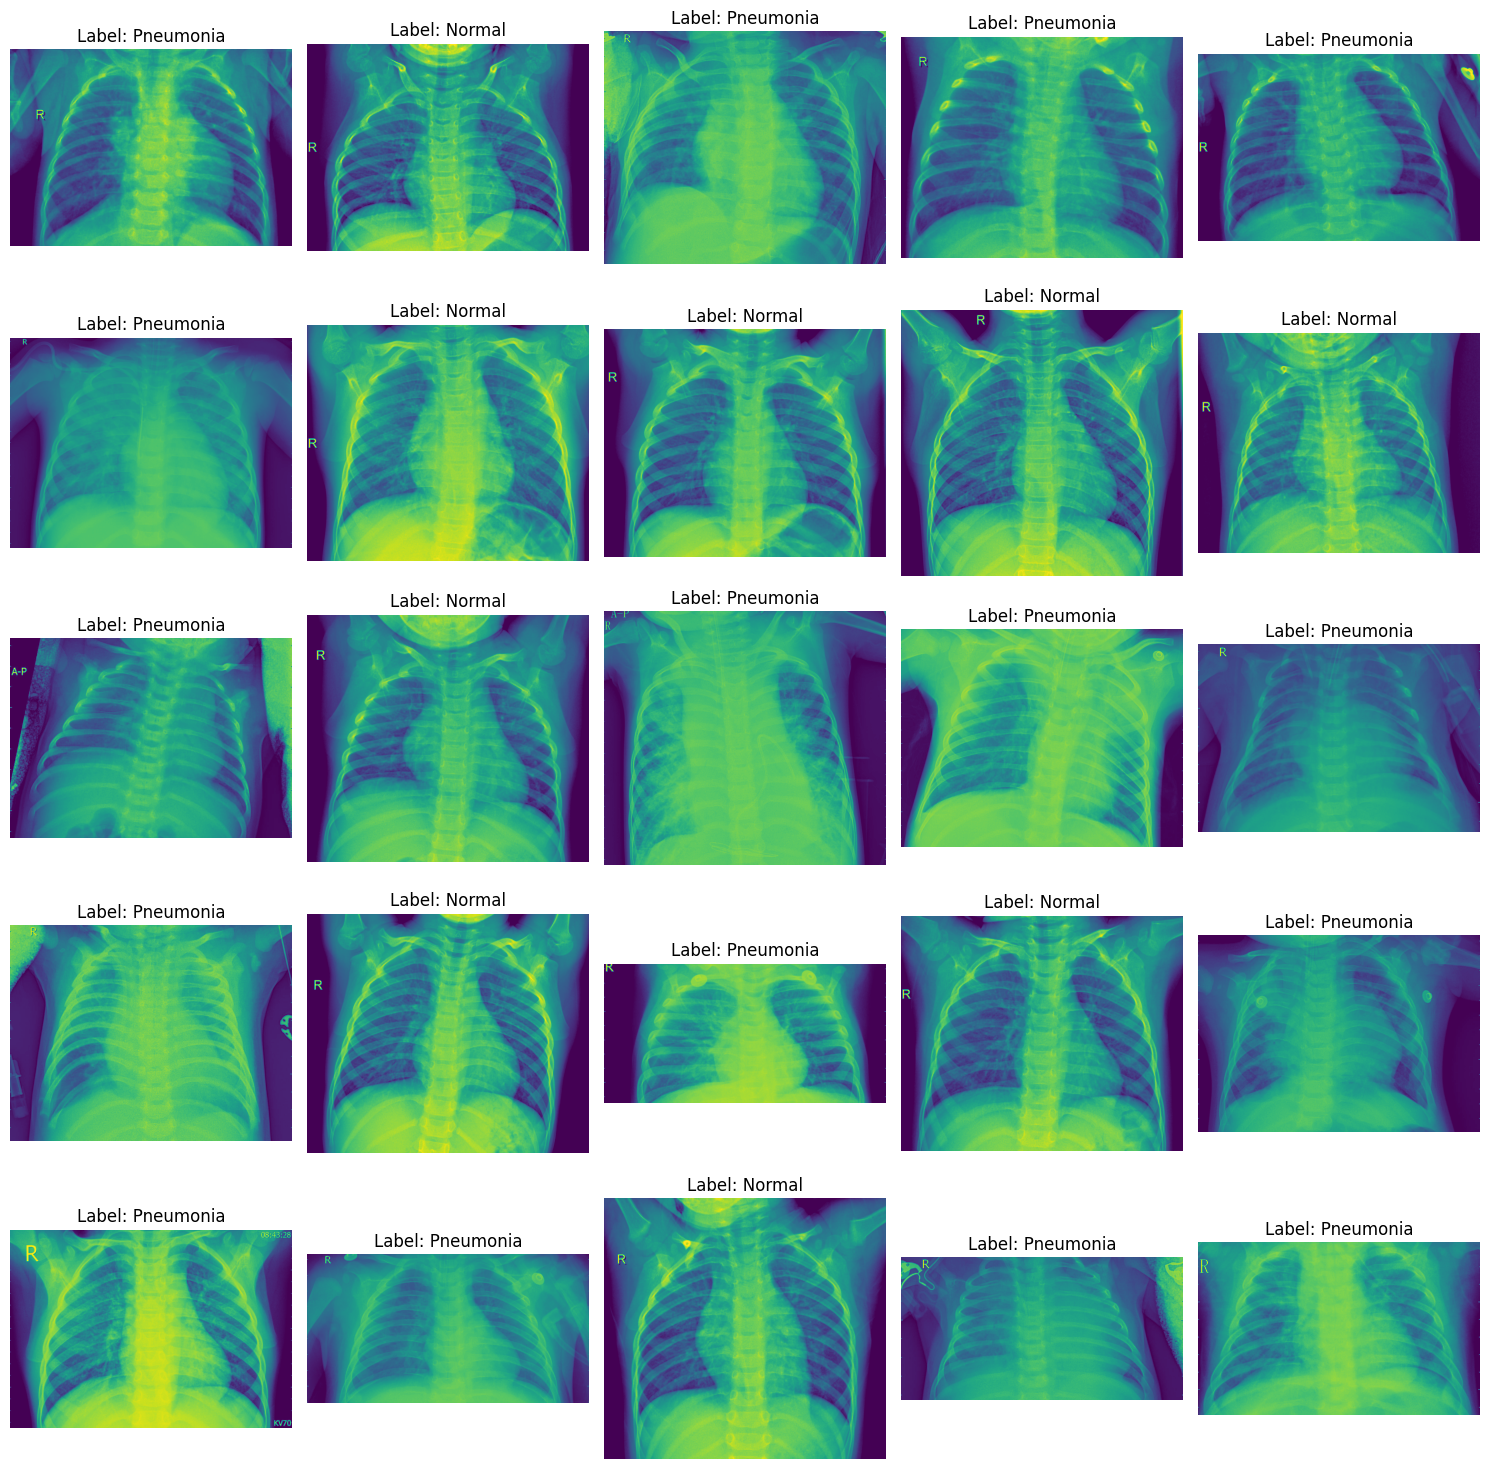

In [ ]:
fig, axes = plt.subplots(5 , 5, figsize=(15, 15))
for i in range(25):
    row = i // 5
    col = i % 5
    image_path = data['image_paths'][i]
    img = Image.open(image_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Label: {data['label'][i]}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
# Data Normalisation
data_dir = '/content/drive/MyDrive/PyTorch'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                 for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training 3 Different Pre-Trained Models
#model1 : ResNet
model1 = models.resnet18(pretrained=True)
num_ftrs = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs, 2) # 2 is the number of classes

#model2 : VGG16
model2 = models.vgg16(pretrained=True)
model2.classifier[6] = torch.nn.Linear(4096, 2)

#model3 : DenseNet
model3 = models.densenet121(pretrained=True)
model3.classifier = torch.nn.Linear(1024, 2)

model_list = {'ResNet' : model1, 'VGG16' : model2, 'DenseNet' : model3}

for name, model in model_list.items():
    print('{} Model Training'.format(name))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.75)
    for epoch in range(10):
        for phase in ['train']:
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('Epoch: {} Loss: {:.4f} Acc: {:.4f} %'.format(epoch + 1, epoch_loss, epoch_acc * 100))

print('Training completed')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can als

ResNet Model Training
Epoch: 1 Loss: 0.4029 Acc: 82.2469 %
Epoch: 2 Loss: 0.3251 Acc: 85.8704 %
Epoch: 3 Loss: 0.2871 Acc: 88.4202 %
Epoch: 4 Loss: 0.2814 Acc: 88.8420 %
Epoch: 5 Loss: 0.2575 Acc: 90.1649 %
Epoch: 6 Loss: 0.2390 Acc: 90.8742 %
Epoch: 7 Loss: 0.2565 Acc: 90.2032 %
Epoch: 8 Loss: 0.2524 Acc: 90.2991 %
Epoch: 9 Loss: 0.2360 Acc: 90.9893 %
Epoch: 10 Loss: 0.2344 Acc: 91.8520 %
VGG16 Model Training
Epoch: 1 Loss: 0.3087 Acc: 87.1549 %
Epoch: 2 Loss: 0.2138 Acc: 91.0660 %
Epoch: 3 Loss: 0.1865 Acc: 92.6189 %
Epoch: 4 Loss: 0.1787 Acc: 93.0023 %
Epoch: 5 Loss: 0.1593 Acc: 93.5775 %
Epoch: 6 Loss: 0.1543 Acc: 94.1718 %
Epoch: 7 Loss: 0.1424 Acc: 94.6511 %
Epoch: 8 Loss: 0.1456 Acc: 94.6702 %
Epoch: 9 Loss: 0.1368 Acc: 94.7086 %
Epoch: 10 Loss: 0.1337 Acc: 94.8620 %
DenseNet Model Training
Epoch: 1 Loss: 0.4235 Acc: 80.7132 %
Epoch: 2 Loss: 0.3084 Acc: 86.9632 %
Epoch: 3 Loss: 0.2863 Acc: 88.8037 %
Epoch: 4 Loss: 0.2694 Acc: 89.3405 %
Epoch: 5 Loss: 0.2614 Acc: 89.8965 %
Epoch:

In [ ]:
import torch.optim as optim
# Data Normalisation
data_dir = '/content/drive/MyDrive/PyTorch'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a transform to augment the data
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/PyTorch/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('NORMAL', 'PNEUMONIA',)
# model1.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for inputs, labels in testloader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     print(f'Accuracy of the model on the test images: {100 * correct / total:.5f}%')
# Evaluate the model on the test data
for name, model in model_list.items():
    net = model
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the {} model on the test images: {} %'.format(name, 100 * correct / total))

Accuracy of the ResNet model on the test images: 68.91025641025641 %
Accuracy of the VGG16 model on the test images: 90.06410256410257 %
Accuracy of the DenseNet model on the test images: 87.5 %
